In [1]:
import sys
sys.path.insert(0, '../')
from utils.GraphAnalytics import GraphAnalytics
from models.Node2Vec import GraphNode2Vec
import numpy as np
import pandas as pd

2023-04-03 21:30:27.823570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 21:30:28.528187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 21:30:28.528225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-03 21:30:28.571844: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-03 21:30:32.153150: W tensorflow/stream_executor/pla

In [2]:
g = GraphAnalytics()
g.load_graph('../data/full_graph_refinitiv')

In [3]:
#while this method causes slower convergence because of the lack of prior, it is still a very healthy train
mu, sigma = 0, .1 # mean and standard deviation
final_embeddings = dict(zip(list(g.nodes),(np.random.normal(mu, sigma, 128) for i in range(len(g.nodes))))) #randomly making embedded nodes

### StellarGraph implementation

https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/hinsage-link-prediction.html

In [4]:
from stellargraph.data import EdgeSplitter
from stellargraph import StellarGraph
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from stellargraph.utils import plot_history
from tensorflow.keras import Model, optimizers, losses, metrics
from tensorflow.keras.utils import plot_model
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

ModuleNotFoundError: No module named 'stellargraph'

In [2]:
#load in with original node2vec embeddings
st_g = g.as_undigraph.copy()
nx.set_node_attributes(
    st_g,
    final_embeddings,
    'node2vec_embeddings',
)
st_g = StellarGraph.from_networkx(st_g, node_features='node2vec_embeddings')

NameError: name 'g' is not defined

In [6]:
#the two really important hyper parameters are different in graph than traditional ML
#test_pred_target_edge_count determines how many of the target edges we drop to later use as test data to evaluate prediction accuracy
#the next cell block ALSO negativly samples nodes without the target edge and trains binary classification between the two node to node datasets
test_pred_target_edge_count = .3
#train_pred_target_edge_count is used to sub sample from the test graph, NOT the original graph
#train_pred_target_edge_count determines how many of the target edges we drop to use in training, aka finding optima via SGD and backprop
#we feed in the drop edges as training data, just like you would feed in labels with a feature set
train_pred_target_edge_count = .99999#0.5
#However! There are still some target edges remaining in the graph. The amount is orig_graph_target_edges * test_pred_target_edge_count * train_pred_target_edge_count
#these remaining target edges are now FEATURES instead of labels. The G_train subgraph can use them in training it's edge prediction classification task
#confused me at first as it adds an additional element of splitting to traditional ML.
#IMO the main reason is that labels can be features. This especially important in time sries graphs, where you may know an acqusition had happened in the previous timestep
#then an LSTM would benefit from that prior state knowledge and make the right adjustment
org_target_count = len([_ for _ in st_g.edges(include_edge_type=True) if _[2]=='ACQUIRED'])
test_target_count = int(org_target_count*(1-test_pred_target_edge_count))
train_target_count = int(test_target_count*(1-train_pred_target_edge_count))

print('Original Target Edges',org_target_count)
print('Target Edges to be held in test dataset, unseen by training, and later used in evaluation', org_target_count-test_target_count)
print('Target Edges to be held in train dataset, used by backprop to opto', test_target_count-train_target_count)
print('Remaining Target Edges turned into features',train_target_count)
#when running the edgesplitter, the test edge splitter should be close to this number, and same with train
num_workers = -1

Original Target Edges 2005
Target Edges to be held in test dataset, unseen by training, and later used in evaluation 602
Target Edges to be held in train dataset, used by backprop to opto 1403
Remaining Target Edges turned into features 0


In [7]:
edge_splitter_test = EdgeSplitter(st_g)
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=test_pred_target_edge_count, method="global", edge_label='ACQUIRED'
)
#setting keep connected as false because
#ValueError: Unable to sample 298 positive edges (could only sample 90 positive edges). Consider using smaller value for p or set keep_connected=False

#this produced edge_ids_test which is a subgraph of original, missing test_pred_target_edge_count of target edges
#and edge_labels_test which is a dataset if positive labels 1 (the acquired edge exists),
#and negative samples, the acquired edge doesn't exist 0
#can bassically run G_test as your training data
#can see when comparing info

Network has 2005 edges of type ACQUIRED
Network has 2005 edges of type ACQUIRED
** Sampled 601 positive and 601 negative edges. **


In [8]:
edge_splitter_test = EdgeSplitter(G_test)
G_train, edge_ids_train, edge_labels_train = edge_splitter_test.train_test_split(
    p=train_pred_target_edge_count, method="global", edge_label='ACQUIRED'
)

Network has 1404 edges of type ACQUIRED
Network has 1404 edges of type ACQUIRED
** Sampled 1403 positive and 1403 negative edges. **


In [9]:
print(edge_ids_test.shape, edge_labels_test.shape)

(1202, 2) (1202,)


In [10]:
print('Sanity check')
for _g in [st_g, G_test, G_train]:
    print(len([_ for _ in _g.edges(include_edge_type=True) if _[2]=='ACQUIRED']))
    #print(_g.info())

Sanity check
2005
1404
1


### Creation of the model

In [11]:
batch_size = 800
epochs = 1000
num_samples=[8]

### Better Train Test Split Methadoloy
https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/graphsage-link-prediction.html

In [12]:
test_generator = HinSAGELinkGenerator(st_g, batch_size=batch_size,
                                      num_samples=num_samples,
                                      head_node_types=["Company", "Company"])
test_gen = test_generator.flow(edge_ids_test, edge_labels_test)

In [13]:
train_generator = HinSAGELinkGenerator(G_train, batch_size=batch_size,
                                       num_samples=num_samples,
                                       head_node_types=["Company", "Company"])
train_gen = train_generator.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [14]:
hinsage_layer_sizes = [32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes, generator=train_generator, bias=True, dropout=0.6
)
x_inp, x_out = hinsage.in_out_tensors()

In [15]:
prediction = link_classification(output_dim=1, output_act="relu", edge_embedding_method="ip")(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [16]:
G_train_nx = G_train.to_networkx()
_g = zip(list(G_train_nx.nodes(data=True)),G_train_nx.degree)
print('Count of layers to be created (max degree within training graph)')
print(sorted([_ for _ in _g if _[0][1].get('label','')=='Company'], key=lambda x: x[1][1], reverse=True)[0][1])

Count of layers to be created (max degree within training graph)
(2365, 27)


###### Model will have n (whatever is above ^) layers based on the amount of n incoming edges for the node with the largest amount of layers
###### In the image below, the node A has 3 incoming edges from 3 adjacent nodes, so each adjacent node gets it's own layer to receive that node's current embedding
###### We take the max, and other layers won't be used
###### BUT when evaluating, because the max is set by training set, some test nodes with higher degrees won't get to read their adjacent node's embeddings
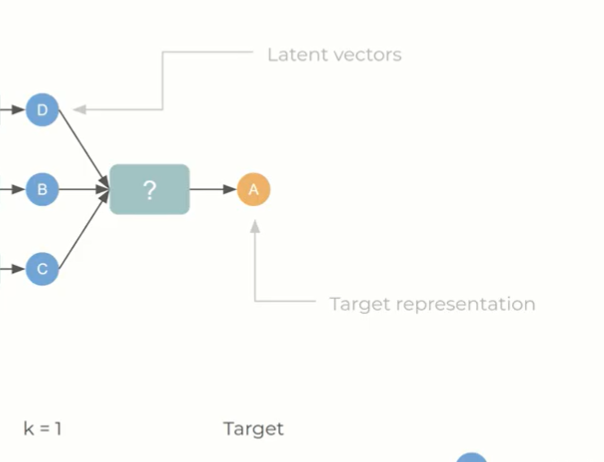


In [17]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=.005),
    loss=losses.binary_crossentropy,
    metrics=['accuracy'],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 128)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 8, 128)]     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 8, 128)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 8, 128)]     0                                            
______________________________________________________________________________________________

C:\Users\nakoo\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
plot_model(model, to_file='../models/current_best_model.png', show_layer_names=True, show_shapes=False)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [19]:
init_train_metrics = model.evaluate(train_gen)
init_test_metrics = model.evaluate(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 1s 143ms/step - loss: 4.2256 - accuracy: 0.5050

Train Set Metrics of the initial (untrained) model:
	loss: 4.2649
	accuracy: 0.5082

Test Set Metrics of the initial (untrained) model:
	loss: 4.2256
	accuracy: 0.5050


In [20]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=test_gen,
                    use_multiprocessing=True,
                    verbose=2,
                    workers=num_workers)

Epoch 1/1000
4/4 - 8s - loss: 4.4891 - accuracy: 0.5032 - val_loss: 3.8426 - val_accuracy: 0.5050
Epoch 2/1000
4/4 - 3s - loss: 3.9350 - accuracy: 0.5096 - val_loss: 3.1667 - val_accuracy: 0.5133
Epoch 3/1000
4/4 - 3s - loss: 3.6817 - accuracy: 0.5057 - val_loss: 2.5311 - val_accuracy: 0.5250
Epoch 4/1000
4/4 - 4s - loss: 3.2349 - accuracy: 0.5110 - val_loss: 1.8057 - val_accuracy: 0.5416
Epoch 5/1000
4/4 - 3s - loss: 2.5840 - accuracy: 0.5103 - val_loss: 1.1403 - val_accuracy: 0.5507
Epoch 6/1000
4/4 - 3s - loss: 2.0909 - accuracy: 0.5192 - val_loss: 0.8248 - val_accuracy: 0.5491
Epoch 7/1000
4/4 - 3s - loss: 1.6149 - accuracy: 0.5282 - val_loss: 0.7295 - val_accuracy: 0.5300
Epoch 8/1000
4/4 - 3s - loss: 1.2334 - accuracy: 0.5296 - val_loss: 0.7208 - val_accuracy: 0.5183
Epoch 9/1000
4/4 - 3s - loss: 1.0089 - accuracy: 0.5296 - val_loss: 0.7233 - val_accuracy: 0.5208
Epoch 10/1000
4/4 - 3s - loss: 0.8342 - accuracy: 0.5292 - val_loss: 0.7404 - val_accuracy: 0.5216
Epoch 11/1000
4/4 -

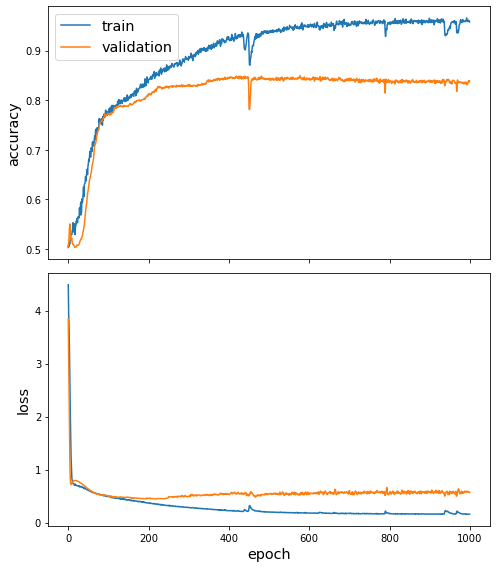

In [22]:
plot_history(history)

In [24]:
train_metrics = model.evaluate(train_gen)
test_metrics = model.evaluate(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 1s 224ms/step - loss: 0.5590 - accuracy: 0.8353

Train Set Metrics of the trained model:
	loss: 0.1247
	accuracy: 0.9519

Test Set Metrics of the trained model:
	loss: 0.5590
	accuracy: 0.8353
